In [1]:

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as anim
from tqdm import tqdm
import random


In [42]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=10., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        self.pz=self.m*0
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        self.Epl = np.zeros(len(t))
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Euler
        self.r += self.dt*self.v
        self.v += self.dt*self.a
        
        # Euler-Cromer
        #self.v += self.dt*self.a
        #self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            
            self.Epl =np.add(self.Epl,((2/3)*self.K*compresion**(3/2)))
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    def GetPotentialEnergy(self,scale=1):
        return self.Epl[::scale] 
    def GetMomentoZ(self,scale=1):
        return self.pz[::scale] 
     
    
    # Debes agregar las paredes en este punto

In [43]:
def GetParticles(N,t):
    Particles=[]

    for i in range(N):
        
        x= float(random.randint(-35, 35))
        y= float(random.randint(-35, 35))
        v= float(random.randint(-5, 5))
       
        r= np.array([x,y])
        v = np.array([v,0])
        a = np.array([0.,0.])
        
        Particles.append(Particle(r,v,a,t,m=1,radius=5,Id=0))
    
    
    
    
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [44]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [45]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [ ]:
def Momento_angularZ(Particles,t):
    MomentoZ= np.zeros(len(t))
     
    for i in Particles:
        
        Momento= np.zeros((len(t)))
        for X in range(len(i.GetPosition())):
            Momento[X]=np.cross(i.GetPosition()[X],i.GetVelocity()[X])
            
            MomentoZ= np.add(MomentoZ , Momento)
    return MomentoZ

Momento_angularZ_=Momento_angularZ(Particles,t1)

In [46]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 10000/10000 [00:05<00:00, 1865.29 Steps/s]


In [47]:
# Bajamos dimensión de la simulacion
scale = 50
t1 = t[::scale]

<IPython.core.display.Javascript object>


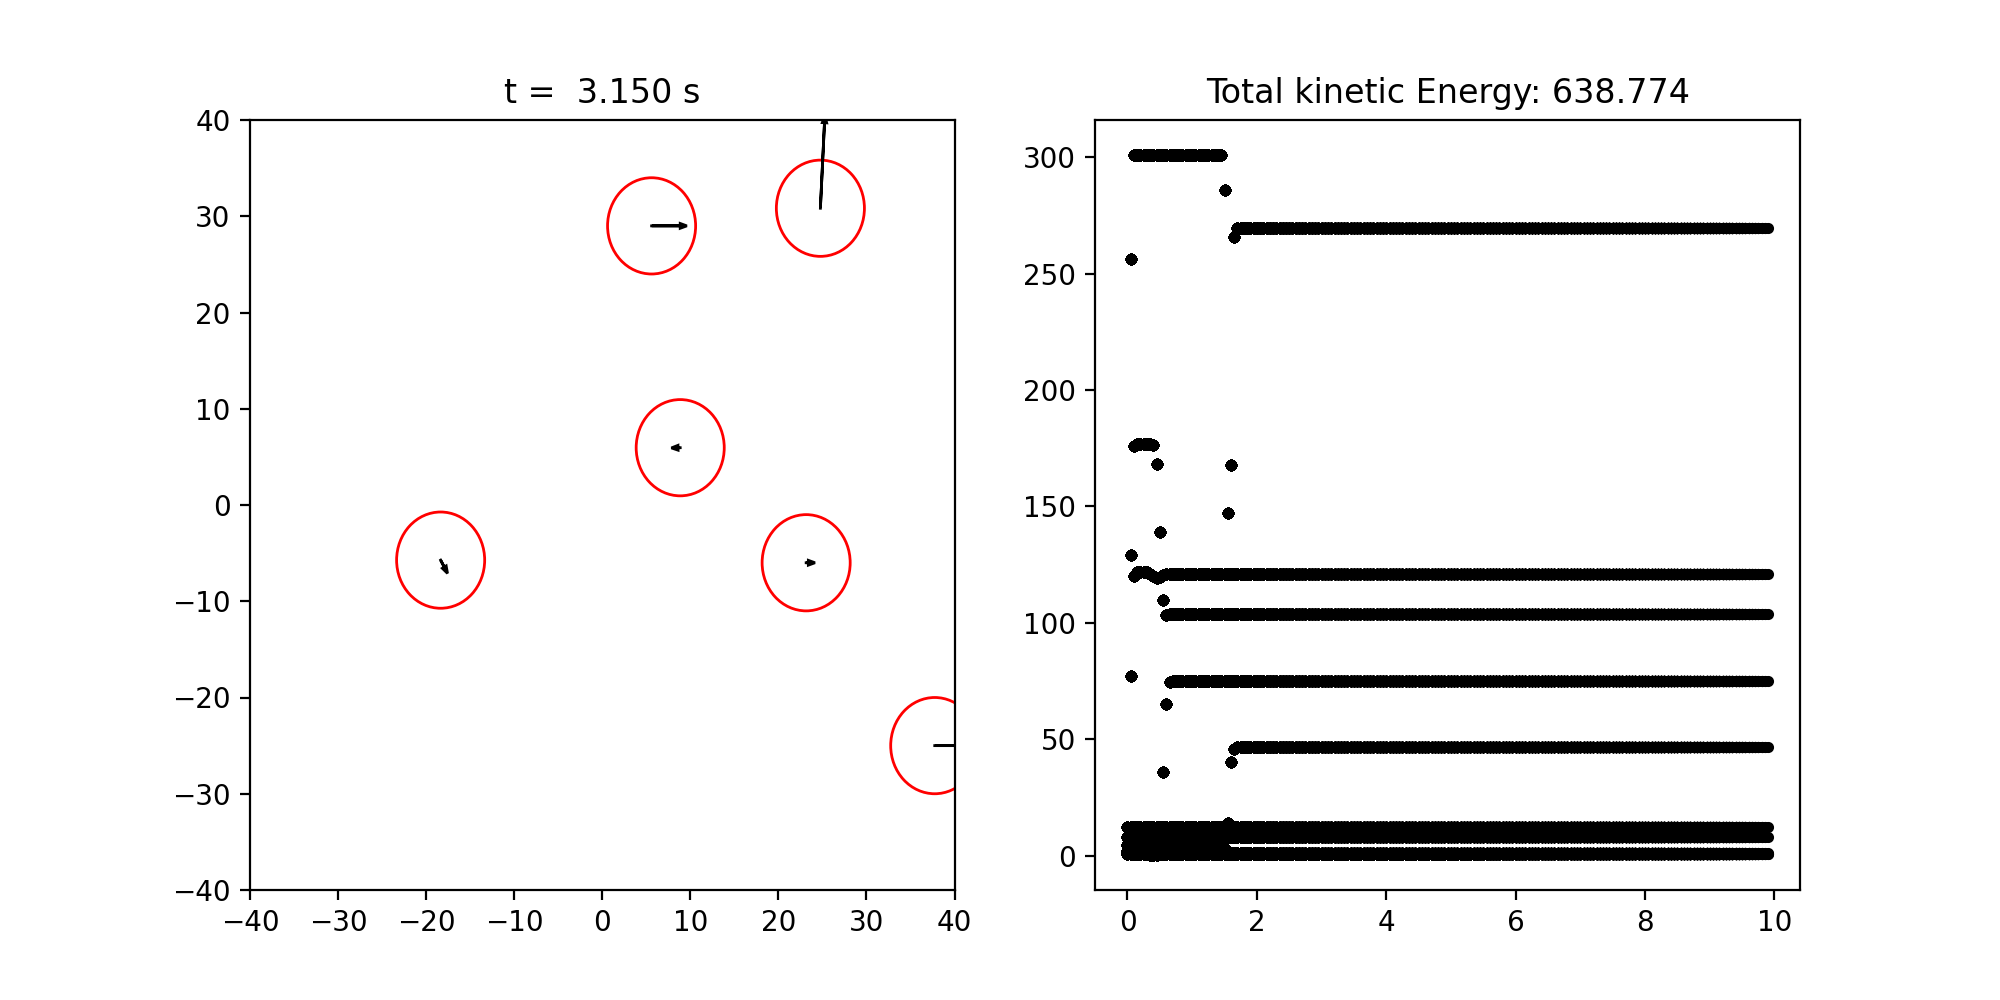

In [48]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-40,40)
    ax.set_ylim(-40,40)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [54]:
def Momento_angularZ(Particles,t,scale):
    MomentoZ= np.zeros(len(t))
     
    for i in Particles:
        
        Momento= np.zeros((len(t)))
        for X in range(len(i.GetPosition(scale))):
            Momento[X]=np.cross(i.GetPosition(scale)[X],i.GetVelocity(scale)[X])
            
            MomentoZ= np.add(MomentoZ , Momento)
    return MomentoZ

Momento_angularZ_=Momento_angularZ(Particles,t1,scale)

In [55]:
MomentumT = Particles[0].GetMomentum(scale)
PotentialE= Particles[0].GetPotentialEnergy(scale)
KineticE= Particles[0].GetKineticEnergy(scale)
print(KineticE[0])

12.5


In [56]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))
for i in range(1,len(Particles)):
    PotentialE = np.add(PotentialE, Particles[i].GetPotentialEnergy(scale))  
for i in range(1,len(Particles)):
    KineticE = np.add(KineticE, Particles[i].GetKineticEnergy(scale))  
Emec=np.add(KineticE, PotentialE)     

<IPython.core.display.Javascript object>


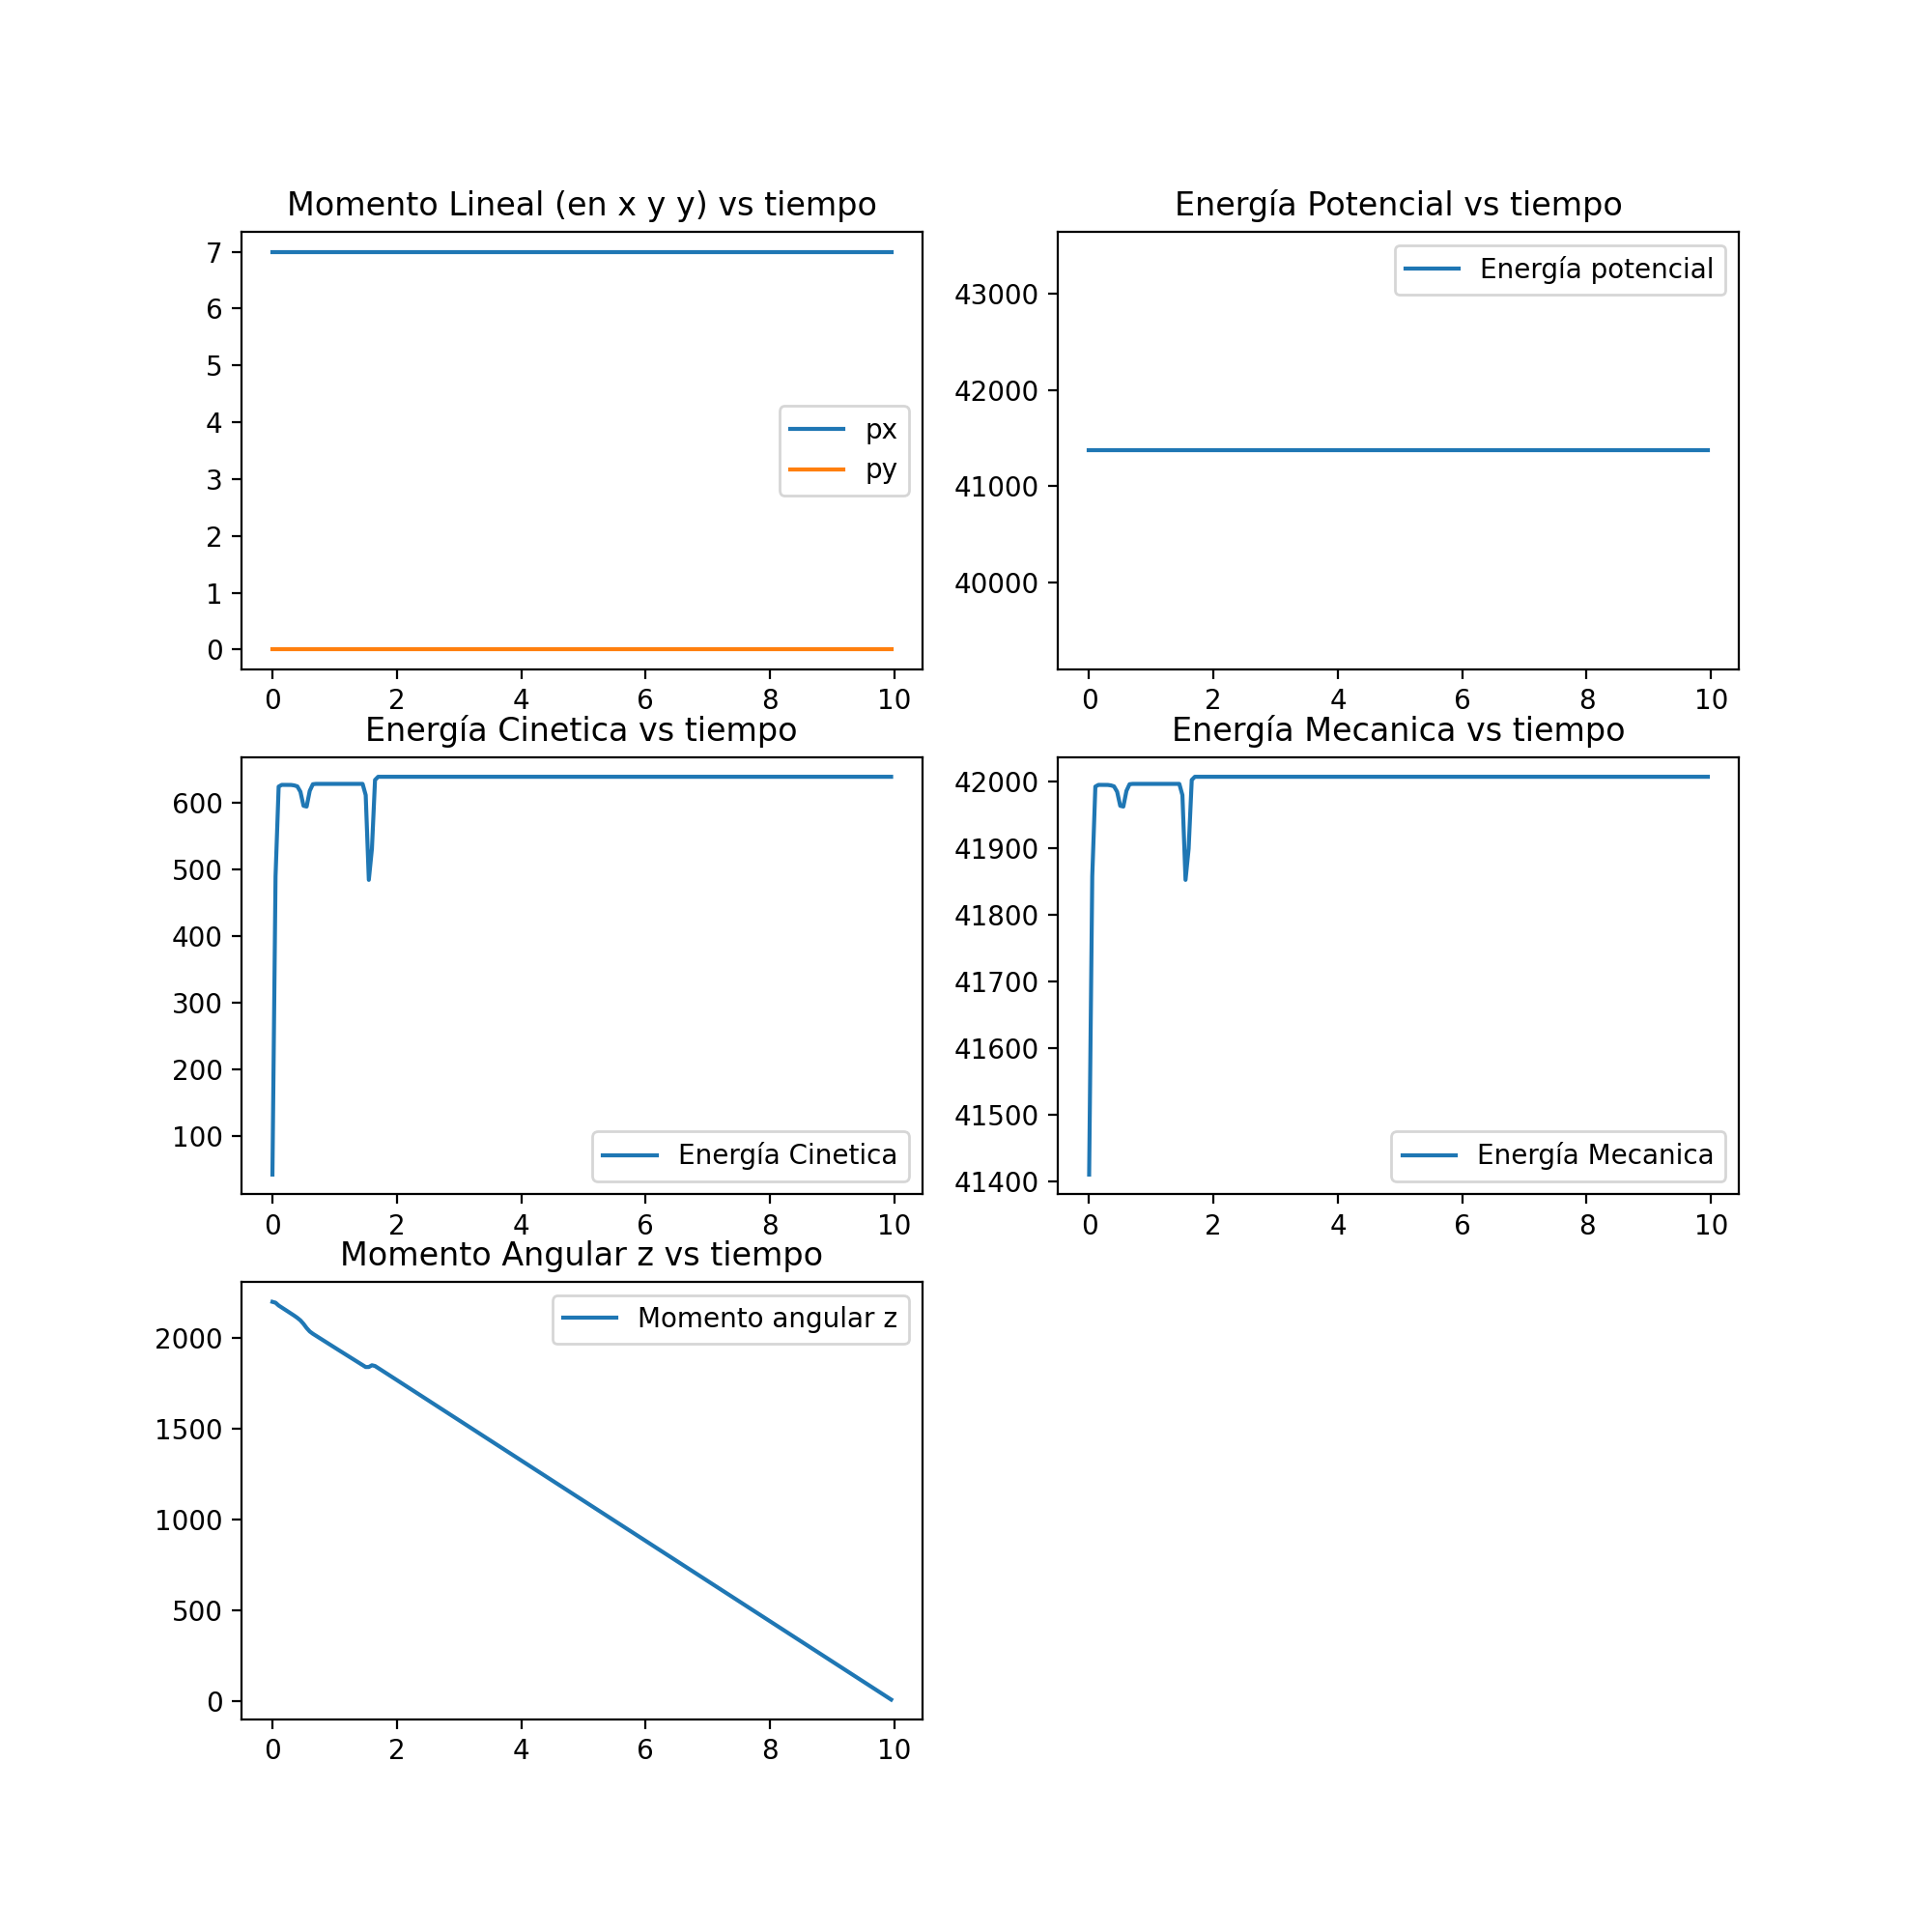

Se debe conservar el momento ya que el momento lineal se conserva en el impacto
La energia potencial positiva significa que hay choques ocurriendo que hacen que exista energia potencial en el sistema.
La energia cinetica parece como si no se conservara en la grafica a pesar de que realmente si se conserva.
La energia mecanica parece no conservarse. Esto es debido a que el metodo de Euler no es estable, entonces no modela bien la situacion fisica.
La pendiente negativa implica que hay una perdida progresiva del momento angular en Z debido a la transferencia de momento y el cambio de la magnitud del momento angular debido al choque de pelotas.
No se cumple el teorema trabajo-energia, ya que la energia cambia sin fuerzas exteriores ejerciendo trabajo


In [66]:
fig3 = plt.figure(figsize=(10,10))
ax3 = fig3.add_subplot(321)
ax4 = fig3.add_subplot(322)
ax5 = fig3.add_subplot(323)
ax6 = fig3.add_subplot(324)
ax7 = fig3.add_subplot(325)

ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.set_title('Momento Lineal (en x y y) vs tiempo')
ax3.legend()

print("Se debe conservar el momento ya que el momento lineal se conserva en el impacto")


ax4.plot(t1,PotentialE,label='Energía potencial')
ax4.set_title('Energía Potencial vs tiempo')
ax4.legend()

print("La energia potencial positiva significa que hay choques ocurriendo que hacen que exista energia potencial en el sistema.")

ax5.plot(t1,KineticE,label='Energía Cinetica')
ax5.set_title('Energía Cinetica vs tiempo')
ax5.legend()

print("La energia cinetica parece como si no se conservara en la grafica a pesar de que realmente si se conserva.")

ax6.plot(t1,Emec,label='Energía Mecanica')
ax6.set_title('Energía Mecanica vs tiempo')
ax6.legend()

print("La energia mecanica parece no conservarse. Esto es debido a que el metodo de Euler no es estable, entonces no modela bien la situacion fisica.")
ax7.plot(t1,Momento_angularZ_,label='Momento angular z')
ax7.set_title('Momento Angular z vs tiempo')
ax7.legend()

print("La pendiente negativa implica que hay una perdida progresiva del momento angular en Z debido a la transferencia de momento y el cambio de la magnitud del momento angular debido al choque de pelotas.")

print("No se cumple el teorema trabajo-energia, ya que la energia cambia sin fuerzas exteriores ejerciendo trabajo")